In [1]:
from models.nn_model_v2 import check_all_attr, dataload_preprocessing
from models.nn_model_v2 import Net, Edu_Data
from models.nn_model_v2 import criterion
from models.nn_model_v2 import train, validate, test,test_various_metric, best_validation_loss
from models.nn_model_v2 import show_data,plot_decision_regions_2class
import time, torch

# import torch
from torch.utils.data import DataLoader, random_split
from torchinfo import summary

# conda install pytorch torchvision -c pytorch
# pip install torchinfo


# Data Preparation

In [2]:
# data loading and preprocessing
check_all_attr() # 주석을 해제해 모든 데이터 특성이름을 확인하세요.


==Data attributes included==
  1 ~  5 |  'female' , 'black' , 'hisp' , 'asian' , 'other'
  6 ~ 10 |  'age' , 'agesq' , 'g11ses' , 'g9ses' , 'g11math'
 11 ~ 15 |  'g9math' , 'hs_par' , 'lfaminc0811' , 'twoparguar' , 'singlepar'
 16 ~ 20 |  'lesshalf' , 'g9nonnative' , 'g9partalkclg' , 'g9schtalkclg' , 'g11catholic'
 21 ~ 25 |  'g11otherprivate' , 'g9catholic' , 'g9otherprivate' , 'g11city' , 'g11suburb'
 26 ~ 30 |  'g11town' , 'g11northeast' , 'g11midwest' , 'g11south' , 'g9city'
 31 ~ 35 |  'g9suburb' , 'g9town' , 'g9northeast' , 'g9midwest' , 'g9south'
 36 ~ 40 |  'm_s2controlsborn_yes' , 's2mcontrolsborn_yes' , 'm_s2controlsstoptrying_yes' , 's2mcontrolsstoptrying_yes' , 'm_s2controlschallenge_yes'
 41 ~ 45 |  's2mcontrolschallenge_yes' , 'repeatg9' , 'high_sci_nosci' , 'high_sci_gensci' , 'high_sci_spesci'
 46 ~ 50 |  'high_sci_advsci' , 'high_sci_apib' , 'exp9ed_dontknow' , 'exp9ed_hs' , 'exp9ed_aa'
 51 ~ 55 |  'exp9ed_ba' , 'exp9ed_grad' , 'exp11ed_hsbroad' , 'exp11ed_aa' , 'exp1

In [3]:

non_use_attr =['age','agesq']
# non_use_attr = [
#     'g11ses' , 'g9ses' , 'g11math',
#     'g9math' , 'hs_par' , 'lfaminc0811' , 'twoparguar' , 'singlepar',
#     'lesshalf' , 'g9nonnative' , 'g9partalkclg' , 'g9schtalkclg' , 'g11catholic',
#     'g11otherprivate' , 'g9catholic' , 'g9otherprivate' , 'g11city' , 'g11suburb',
#     'g11town' , 'g11northeast' , 'g11midwest' , 'g11south' , 'g9city',
#     'g9suburb' , 'g9town' , 'g9northeast' , 'g9midwest' , 'g9south',
#     'm_s2controlsborn_yes' , 's2mcontrolsborn_yes' , 'm_s2controlsstoptrying_yes' , 's2mcontrolsstoptrying_yes' , 'm_s2controlschallenge_yes' ,      
#     's2mcontrolschallenge_yes' , 'repeatg9' , 'high_sci_nosci' , 'high_sci_gensci' , 'high_sci_spesci',
#     'high_sci_advsci' , 'high_sci_apib' , 'exp9ed_dontknow' , 'exp9ed_hs' , 'exp9ed_aa',
#     'exp9ed_ba' , 'exp9ed_grad' , 'exp11ed_hsbroad' , 'exp11ed_aa' , 'exp11ed_ba',
#     'exp11ed_grad' , 'req_ed_occ09_notknow' , 'reqed_occ09_hs' , 'reqed_occ09_aa' , 'reqed_occ09_ba',
#     'reqed_occ09_grad' , 'req_ed_occ12_notknow' , 'reqed_occ12_hs' , 'reqed_occ12_aa' , 'reqed_occ12_ba',
#     'reqed_occ12_grad']
X, y = dataload_preprocessing(non_use_attr)


Number of data attributes:  66
2  data attributes are removed.
Number of data attributes in Traing/Testing process:  64


# DNN Experiments

##### 변경해볼만한 변수들
##### non_use_attr: 주어진 데이터셋에서 학습에 활용하지 않을 설명변수명을 입력 -> 설명변수 조건 다양화, 성능과 큰 관련을 갖는 설명변수를 찾을 수 있음.
##### epochs: 모델이 전체 데이터셋을 학습하는 횟수 -> 큰 값으로 설정할수록 훈련시간 증가
##### batch_size: 모델이 학습할때 한번에 모든 데이터를 학습하는게 아니라, 분할해 학습하게 됩니다. 이때 분할의 유닛사이즈를 의미합니다. -> 값이 작을수록 세밀하게 데이터를 학습할 수 있지만, 세밀한 학습이 정확도 향상을 항상 보장하진 않습니다.
##### optimizer: 모델의 추론 오류를 개선(반영)하는 방식 -> 다른 훈련파라미터들과 함께 조합해 사용. SGD, ADAM, AdaDelta 가 일반적으로 좋은 성능을 냄

##### Dataset Preparation for DNN Training/Testing

In [4]:
batch_size = 32

data_set = Edu_Data(X,y)
train_size = int(len(X) * 0.7)
val_size = int(train_size * 0.15)
test_size = len(X) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(data_set, lengths=[train_size, val_size, test_size])
test_dataset+=val_dataset
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

##### DNN Model Params

In [5]:
input_dim = len(X.columns)
hidden_dim = 512
dropout_r = 0.2
output_dim = 2
model = Net(input_dim, hidden_dim, output_dim, dropout=dropout_r)

##### DNN Model Summary

In [6]:
print(model) # 간략한 모델 설명

summary(model, input_size=(batch_size,input_dim)) #구체적인 모델 설명

Net(
  (linear1): Linear(in_features=64, out_features=512, bias=True)
  (dp1): Dropout(p=0.2, inplace=False)
  (linear2): Linear(in_features=512, out_features=64, bias=True)
  (linear3): Linear(in_features=64, out_features=2, bias=True)
)


Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [32, 2]                   --
├─Linear: 1-1                            [32, 512]                 33,280
├─Dropout: 1-2                           [32, 512]                 --
├─Linear: 1-3                            [32, 64]                  32,832
├─Linear: 1-4                            [32, 2]                   130
Total params: 66,242
Trainable params: 66,242
Non-trainable params: 0
Total mult-adds (M): 2.12
Input size (MB): 0.01
Forward/backward pass size (MB): 0.15
Params size (MB): 0.26
Estimated Total Size (MB): 0.42

##### Training Params

In [7]:
epochs = 10 # The number of repeation for training whole dataset
learning_rate = 0.001 # 

# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# optimizer = torch.optim.Adadelta(model.parameters(), lr=learning_rate)

##### Training procedure

In [8]:
for epoch in range (epochs):
    time_start = time.time()

    train_loss, train_accuracy = train(model, criterion, train_loader, optimizer)
    validation_loss, validation_accuracy = validate(model, val_loader)

    time_end = time.time()
    time_delta = time_end - time_start

    if validation_loss < best_validation_loss:
        best_validation_loss = validation_loss
        torch.save(model, 'nnmodel.pt')

    print(f'epoch number: {epoch + 1} | time elapsed: {time_delta}s')
    print(f'training loss: {train_loss:.3f} |  training accuracy: {train_accuracy * 100:.2f}%')
    print(f'validation loss: {validation_loss:.3f} |  validation accuracy: {validation_accuracy * 100:.2f}%')
    print()

epoch number: 1 | time elapsed: 1.5957841873168945s
training loss: 0.009 |  training accuracy: 90.97%
validation loss: 0.007 |  validation accuracy: 91.78%

epoch number: 2 | time elapsed: 1.5949246883392334s
training loss: 0.008 |  training accuracy: 91.74%
validation loss: 0.007 |  validation accuracy: 92.01%

epoch number: 3 | time elapsed: 1.5467760562896729s
training loss: 0.008 |  training accuracy: 91.72%
validation loss: 0.008 |  validation accuracy: 91.67%

epoch number: 4 | time elapsed: 1.5310826301574707s
training loss: 0.007 |  training accuracy: 91.95%
validation loss: 0.008 |  validation accuracy: 92.36%

epoch number: 5 | time elapsed: 1.6247596740722656s
training loss: 0.007 |  training accuracy: 92.08%
validation loss: 0.008 |  validation accuracy: 92.25%

epoch number: 6 | time elapsed: 1.5154929161071777s
training loss: 0.007 |  training accuracy: 92.38%
validation loss: 0.008 |  validation accuracy: 92.01%

epoch number: 7 | time elapsed: 1.5310859680175781s
traini

##### Testing with Best Performance Model

In [9]:
# from sklearn.metrics import f1_score  
best_model = torch.load('nnmodel.pt')
test_loss, test_accuracy, result = test(best_model, test_loader)
print(f'Test loss: {test_loss:.3f} | test: {test_accuracy * 100:.3f}%')
# print(f'Test F1: {f1_score:.3f}')

Test loss: 0.008 | test: 91.457%


In [10]:
f1_score,recall = test_various_metric(best_model, test_loader)

print(f'Test F1Score: {f1_score:.3f}')
print(f'Test Recall: {recall:.3f}')


Test F1Score: 0.952


##### Data analyses

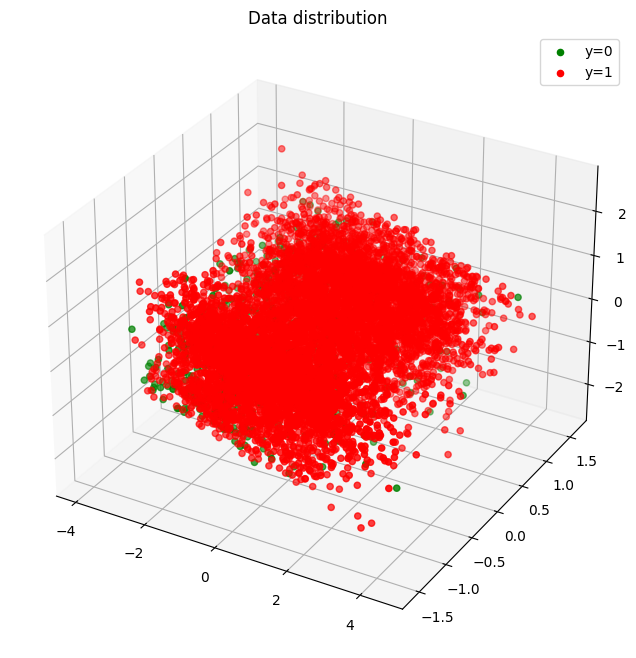

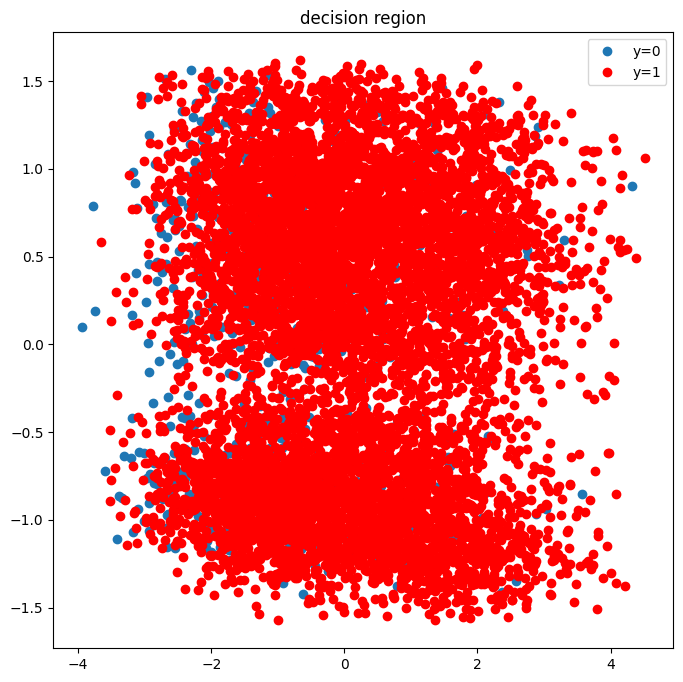

In [11]:
show_data(X, y)
plot_decision_regions_2class(X, y)

# ML Experiments

In [12]:
from models.nn_model_v2 import check_all_attr, dataload_preprocessing_svm
from sklearn.model_selection import train_test_split
import numpy as np
from itertools import product
import matplotlib.pyplot as plt
from sklearn.ensemble import VotingClassifier
# from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import classification_report
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression

# pip install ipykernel
# pip3 install torch torchvision
# pip install pandas
# pip install matplotlib
# pip install torchsummary

In [20]:
X, y = dataload_preprocessing_svm(non_use_attr)
y = np.asarray(y).ravel()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)


Number of data attributes:  66
2  data attributes are removed.
Number of data attributes in Traing/Testing process:  64


##### ML Model Preparation

In [21]:
# Training Classifiers
clf1 = DecisionTreeClassifier(max_depth=5, random_state=42)
clf2 = RandomForestClassifier(n_estimators=10, random_state=42)
clf3 = AdaBoostClassifier(n_estimators=100, random_state=42)
clf4 = SVC(gamma=0.1, kernel="rbf", probability=True, random_state=42)
clf5 = SVC(gamma=0.1, kernel="poly", probability=True, random_state=42)
clf6 = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
clf7 = LogisticRegression(max_iter=1000, random_state=42)
eclf = VotingClassifier(estimators=[("dt", clf1), ("randomforest", clf1), ("svc", clf3)], voting="soft", weights=[2, 1, 2])

In [22]:
classifiers = [clf1, clf2, clf3, clf4, clf5, clf6, clf7, eclf]
clf_name = ['DecisionTree', 'RandomForest', 'ADaBoost','SVM(RBF)', 'SVM(POLY)', 'SGDClassifier', 'LogisticRegression', 'Soft Voting']
target_names = ['pass', 'dropout']

##### ML Model Training

In [23]:
for i, clf in enumerate(classifiers):
    clf = clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print('-----------------------------------------------------')
    score = accuracy_score(y_test, y_pred)
    print(' %s accuracy_score:  %.3f' % (clf_name[i], score))
    print('-----------------------------------------------------')
    print(classification_report(y_test, y_pred, target_names=target_names))

-----------------------------------------------------
 DecisionTree accuracy_score:  0.905
-----------------------------------------------------
              precision    recall  f1-score   support

        pass       0.91      1.00      0.95      2231
     dropout       0.63      0.05      0.09       239

    accuracy                           0.91      2470
   macro avg       0.77      0.52      0.52      2470
weighted avg       0.88      0.91      0.87      2470

-----------------------------------------------------
 RandomForest accuracy_score:  0.904
-----------------------------------------------------
              precision    recall  f1-score   support

        pass       0.91      0.99      0.95      2231
     dropout       0.51      0.08      0.13       239

    accuracy                           0.90      2470
   macro avg       0.71      0.53      0.54      2470
weighted avg       0.87      0.90      0.87      2470

-----------------------------------------------------
 A

##### ML Model Testing

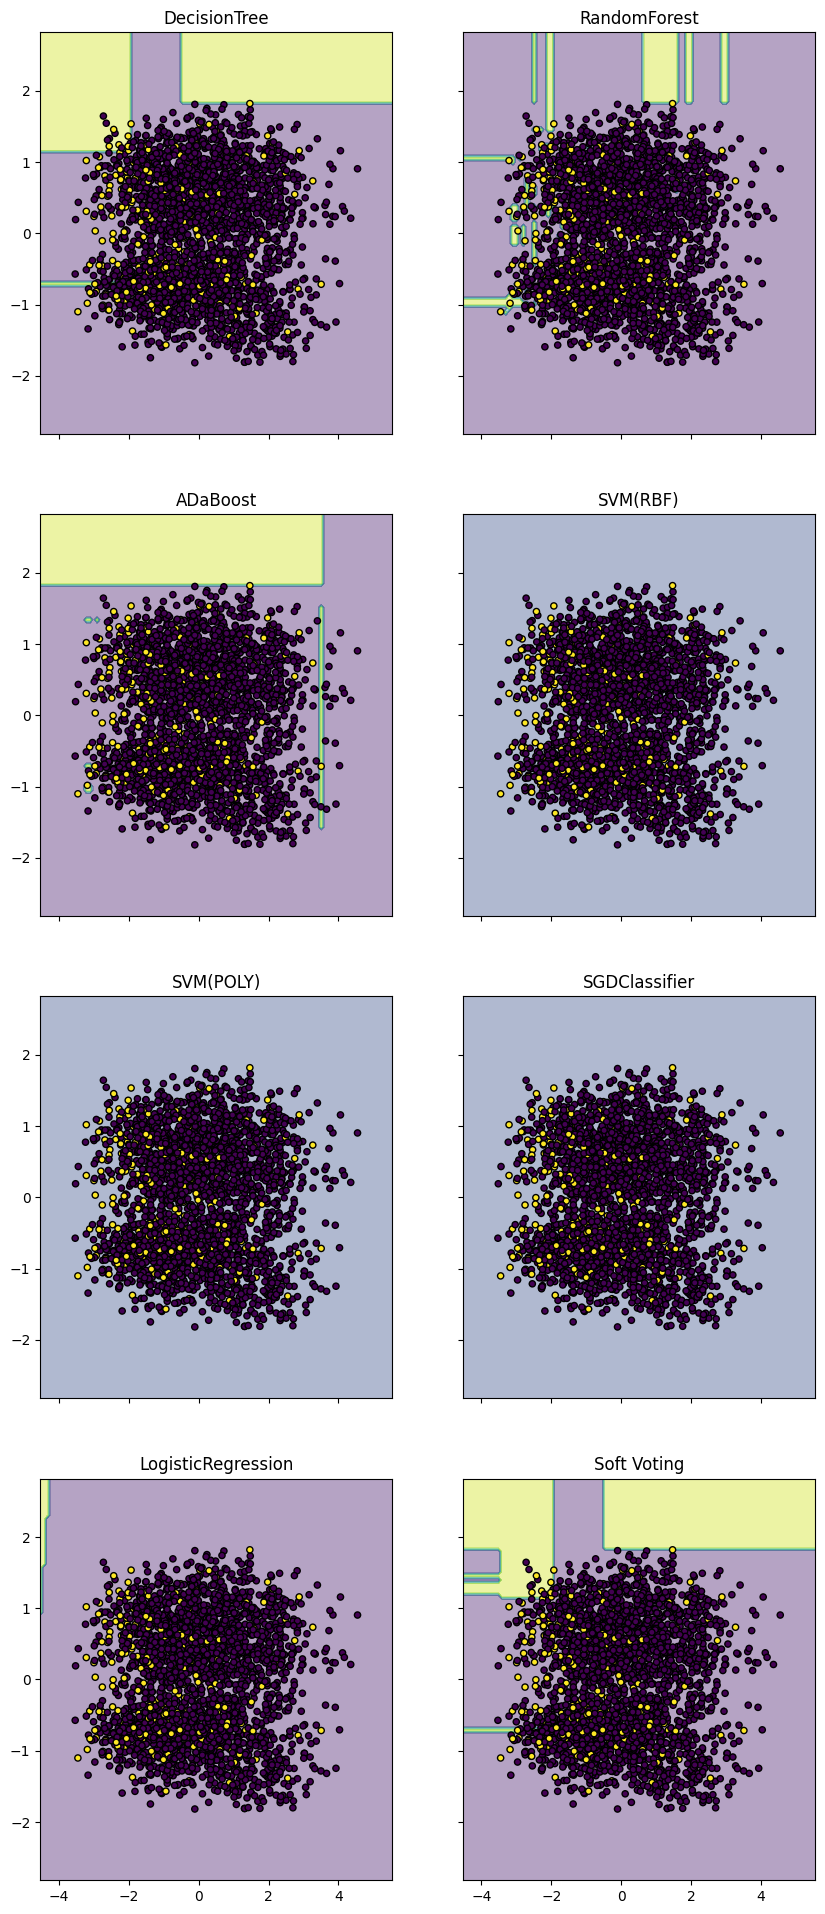

In [24]:
from sklearn.decomposition import PCA
from sklearn.inspection import DecisionBoundaryDisplay

pca = PCA(n_components=2)
X_pca_test = pca.fit_transform(X_test)

clf1 = DecisionTreeClassifier(max_depth=5, random_state=42)
clf2 = RandomForestClassifier(n_estimators=10, random_state=42)
clf3 = AdaBoostClassifier(n_estimators=100, random_state=42)
clf4 = SVC(gamma=0.1, kernel="rbf", probability=True, random_state=42)
clf5 = SVC(gamma=0.1, kernel="poly", probability=True, random_state=42)
clf6 = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
clf7 = LogisticRegression(max_iter=1000, random_state=42)
eclf = VotingClassifier(estimators=[("dt", clf1), ("randomforest", clf1), ("svc", clf3)], voting="soft", weights=[2, 1, 2])

for i, clf in enumerate(classifiers):
    clf = clf.fit(X_pca_test, y_test)

# Plotting decision regions
f, axarr = plt.subplots(4, 2, sharex="col", sharey="row", figsize=(10, 24))
for idx, clf, tt in zip(product([0, 1, 2, 3], [0, 1]), classifiers, clf_name):
    DecisionBoundaryDisplay.from_estimator(clf, X_pca_test, alpha=0.4, ax=axarr[idx[0], idx[1]], response_method="predict")
    axarr[idx[0], idx[1]].scatter(X_pca_test[:, 0], X_pca_test[:, 1], c=y_test, s=20, edgecolor="k")
    axarr[idx[0], idx[1]].set_title(tt)

plt.show()